# Домашняя работа. Решающие деревья и леса. kNN. SVM

## Общая информация

Дата выдачи: 22.08.2021

Срок сдачи: 05.09.2021 09:00MSK


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Обратите внимание, что только за реализацию функций без подтверждения их корректной работы оценка выставляться не будет.

Задание выполняется САМОСТОЯТЕЛЬНО. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 4 баллов.

При сдаче после указанного срока сдачи от выставленной оценки за работу будет отниматься 0.5 балла за каждые 24 часа просрочки.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: Username_hw9.ipynb, где Username — ваша фамилия на латинице (например, Kozlova_hw9.ipynb). Далее отправьте этот файл на почту pfilipovich@ibagroup.eu с темой письма "homework_09.%FULL_NAME%" с указанными выше условиями.

In [1]:
conda install python-graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Импорт модулей

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

import math

## Постановка задачи

Давайте рассмотрим следующую задачу: зная информацию о пациенте попробуем предсказать есть ли у него сердечное заболевание. Каждый пациент будет описываться 13 признаками, включающими в себя возраст, пол, информацию из электрокардиограммы и т.д.

Загрузите данные из файла *heart.dat.txt*, используя пандас, в переменную *data* (разделитель полей — пробел). Значение целевой переменной находится в последней колонке (*Absence_(1)_or_presence_(2)_of_heart_disease*). 

In [3]:
data = pd.read_csv('heart.dat.txt', sep=' ')

Выделите признаки в переменную *X*, а целевую зависимость — в *y*.

In [4]:
labels =  data.iloc[:, :-1].columns
X, y = data.iloc[:, :-1].values, data.iloc[:,-1].values

В начале рассмотрим решающее дерево. Как известно, одно дерево обладает плохой обобщающей сопособностью, поэтому стоит подбирать параметры, такие как высота дерева и минимальное число объектов в листе, для уменьшения этого явления.

Для оценки качества будем использовать 5-Fold кросс-валидацию с метрикой *AUC-ROC*. Создайте объект [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html) со следующими параметрами:
 - первым параметром нужно передать количество объектов в выборке
 - *n_folds* равно 5
 - установить *shuffle=True*, чтобы объекты были перемешаны перед разбиением
 - зафиксировать *random_state*

In [5]:
kfold = KFold(n_splits=5, random_state=0, shuffle=True)

Теперь воспользуемся функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) для оценки качества. Она принимает следующие параметры:
 - *estimator* — в данном случае им будет решающее дерево [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Здесь и далее фиксируйте параметр *random_state* у решающего дерева, чтобы результат был воспроизводим. В этом пункте ограничения на другие параметры не накладываются
 - *X* и *y* — матрица "объект-признак" и значение целевой переменной соответственно
 - *scoring* просто указать *roc_auc_score*
 - *cv* — передать созданный ранее kfold
 
Эта функция возвращает массив значений качества на каждом разбиении. 

Опционарно использовать [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) для перебора признаков - в дополнение к перебору комбинаций признаков руками.

**(1 балл)** Посчитайте среднее, минимальное и максимальное качество, которое получатеся с помощью решающего дерева.

In [6]:
# no depth limits:
tree_est = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(tree_est, X, y, scoring='roc_auc', cv=kfold)

print('Min:', np.min(scores))
print('Max:', np.max(scores))
print('Mean:', np.mean(scores))

Min: 0.6666666666666667
Max: 0.8365384615384616
Mean: 0.758254662004662


**(0.5 балла)** Теперь попробуем посмотреть изменится ли оно, если ограничить высоту дерева. Зафиксируйте высоту дерева равной 3 и повторите аналогичные действия. Увеличились ли показания качества по сравнению с прошлым разом?

**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

In [7]:
# depth limit- 3:
cut_tree_est = DecisionTreeClassifier(random_state=0, max_depth = 3)
cut_scores = cross_val_score(cut_tree_est, X, y, scoring='roc_auc', cv=kfold)

print('Min:', np.min(cut_scores))
print('Max:', np.max(cut_scores))
print('Mean:', np.mean(cut_scores))

Min: 0.7890625
Max: 0.9339488636363635
Mean: 0.8568473887223886


*В действительности, показания улучшились, что может быть связано с переобученность первого дерева, ибо разбиение в нём продолжается пока `impurity` == 0 или `samples` < 2*

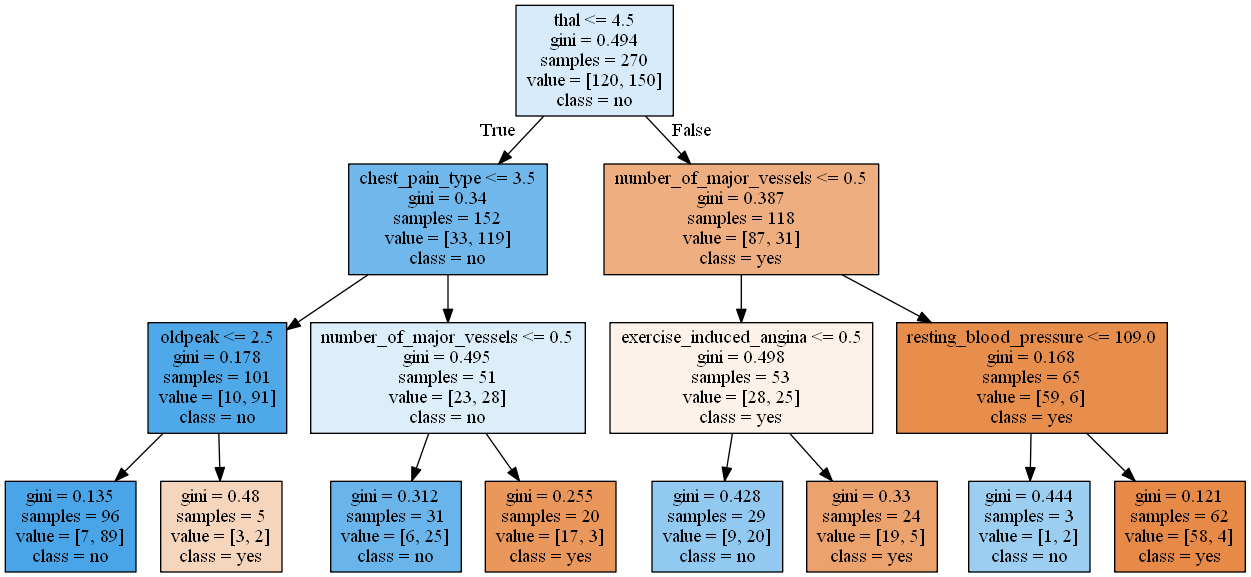

**(0.5 балла)** А принесет ли улучшение, если ограничить высоту дерева 1? 

**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

In [8]:
# depth limit- 1:
stump_est = DecisionTreeClassifier(random_state=0, max_depth = 1)
stump_scores = cross_val_score(stump_est, X, y, scoring='roc_auc', cv=kfold)

print('Min:', np.min(stump_scores))
print('Max:', np.max(stump_scores))
print('Mean:', np.mean(stump_scores))

Min: 0.6708333333333333
Max: 0.7855113636363638
Mean: 0.7243029886779886


*В данном случае наш "пенёк" лишь ухудшил результаты, чего и следовало ожидать, ведь он тут один*

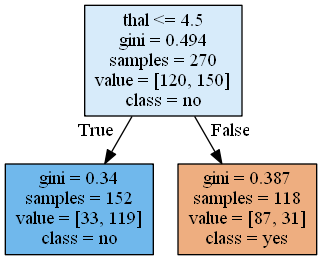

**(1 балл)** Напишите почему наложение ограничения на высоту дерева влияет на его обобщающую способность. Почему деревья глубиной 1 по одиночке могут быть неэффективны?

*При `излишней` высоте дерева полученный классификатор идеально отвечает параметрам тренировочного набора данных, имеет место место переобученность, плохая способность к обобщению. В то же время, `слишком малая` высота дерева может так же демонстрировать не самый лучший эфект, в особенности если это дерево одно, поскольку разбииение происходит лишь по одному параметру по одному набору данных. Если же мы имеем дело с ансамблем деревьев, то полученные результаты являются усреднёнными от предсказаний по нескольким параметрам*

**(2 балла)** Теперь попробуем провести аналогичные эксперименты для случая решающего леса [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Рассмотрите 10, 50 и 100 деревьев в случайном лесу (поле *n_estimators*) для высоты деревьев по умолчанию, 3 и 1 (поле *max_depth*). Не забудьте зафиксировать *random_state*. Улучшается ли качество при увеличении количества деревьев в лесу? Сильно ли влияет ограничение на высоту деревьев при построении леса?

In [9]:
parameters = {'max_depth':(1, 3), 'n_estimators':(10, 50, 100), }

grc_est = GridSearchCV(RandomForestClassifier(random_state=0),
                       parameters, scoring='roc_auc',
                       cv=kfold, return_train_score = True)
grc_est.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': (1, 3), 'n_estimators': (10, 50, 100)},
             return_train_score=True, scoring='roc_auc')

In [10]:
params_table = (pd.concat([pd.DataFrame(grc_est.cv_results_["params"]),
           pd.DataFrame(grc_est.cv_results_["mean_test_score"],
                        columns=["Mean Accuracy"]),
           pd.DataFrame(grc_est.cv_results_["split4_test_score"],
                        columns=["Final Accuracy"])],axis=1)).set_index(['max_depth','n_estimators'])
params_table

Mean Accuracy  Final Accuracy
max_depth n_estimators                               
1         10                 0.879552        0.904119
          50                 0.892891        0.925426
          100                0.902692        0.928977
3         10                 0.884577        0.900568
          50                 0.905018        0.940341
          100                0.915104        0.948864

*Как можно видеть из приведённой таблицы, качество модели в заданной метрике действительно `увеличивается` при возрастании количества деревьев в лесу. Что касается ограничения по размеру дерева, то оно так же влияет на скор, и, на мой взгляд, довольно значительно влияет. Однако в некоторых случаех это может быть скомпенсировано увеличением кол- ва деревьев в лесу вкупе с bootstrap'ом*

**(1 балл)** И напоследок посмотрим, какие признаки являются наиболее *важными*. Обучите решающий лес с оптимальными на ваш взгляд параметрами (можете опираться на эксперименты ранее) на всей выборке и посмотрите на поле *feature\_importances\_* у обученного леса. Выпишите названия наиболее и наименее важных признаков с точки зрения случайного леса. 

In [11]:
forest_est = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=3, bootstrap=True)
model_fit = forest_est.fit(X,y)

In [12]:
importance_table = pd.DataFrame(model_fit.feature_importances_, index = labels, columns=['Rate'])
importance_table.nlargest(5, ['Rate'])

,Rate
thal,0.217094
chest_pain_type,0.171741
number_of_major_vessels,0.129562
oldpeak,0.121099
maximum_heart_rate_achieved,0.093967


Итого, вот они слева направо: `thal`, `chest_pain_type`,`number_of_major_vessels`, `oldpeak`, `maximum_heart_rate_achieved` (в порядке убывания)

**(2 балла)** Попробуем провести аналогичные эксперименты для kNN [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). Рассмотрите не менее 5-х различных N (поле *n_neighbors*, обязательно включая [1, 5, 21]), попробуйте изменять функцию (не менее 3-х) для определения расстояния в пространстве (поле *metric*). Как влияет количество соседей на получаемый результат? Каким образом подбирали остальные величины количества соседей? Как влияние функции определения расстояния в пространстве?

In [13]:
parameters = {'n_neighbors':(1, 5, 10, 15, 21, 35),
              'metric':('euclidean', 'manhattan', 'chebyshev', 'minkowski')}

neighbours_est = GridSearchCV(KNeighborsClassifier(),
                       parameters, scoring='roc_auc',
                       cv=kfold, return_train_score = True)

#the best params found
neighbours_est.fit(X,y).best_params_ 

{'metric': 'manhattan', 'n_neighbors': 21}

In [14]:
params_table = (pd.concat([pd.DataFrame(neighbours_est.cv_results_["params"]),
           pd.DataFrame(neighbours_est.cv_results_["mean_test_score"],
                        columns=["Mean Accuracy"]),
           pd.DataFrame(neighbours_est.cv_results_["split4_test_score"],
                        columns=["Final Accuracy"])],axis=1)).set_index(['metric', 'n_neighbors'])

params_table

Mean Accuracy  Final Accuracy
metric    n_neighbors                               
euclidean 1                 0.577266        0.686080
          5                 0.699738        0.683239
          10                0.724947        0.664062
          15                0.730557        0.668324
          21                0.736291        0.686080
          35                0.725372        0.649858
manhattan 1                 0.646052        0.771307
          5                 0.758736        0.757102
          10                0.772671        0.748580
          15                0.786856        0.725852
          21                0.786931        0.699574
          35                0.784936        0.717330
chebyshev 1                 0.587363        0.654830
          5                 0.693628        0.677557
          10                0.716797        0.700994
          15                0.713176        0.680398
          21                0.714370        0.664062
          35                0.724391        0.667614
minkowski 1                 0.577266        0.686080
          5                 0.699738        0.683239
          10                0.724947        0.664062
          15                0.730557        0.668324
          21                0.736291        0.686080
          35                0.725372        0.649858

*Увеличение числа ближайших соседей более чем 15 шт, в целом, оказывало негативное влияние на характеристики модели. Соседи выбираются на основании метрики расстояния по приницпу k ближайших. В зависимости от метрики менялся скор полученных результатов. Наилучшие для данного датасета результаты достигаются при манхэттенской метрике.*

**(2 балла)** Попробуем провести аналогичные эксперименты для SVM [SVC (Support Vector Classifier)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Рассмотрите различные ядра (поле *kernel*, [linear, poly, rbf, sigmoid]), для [poly] попробуйте разные степени полинома, не менее 4 (поле *degree*, обязательно попробуйте [1,3]). Как влияют разные ядра на получаемый результат? Как влияет степень полинома на результат?

In [15]:
parameters1 = {'kernel':['poly'],
              'degree':(1, 2, 3, 5, 10, 20)}
parameters2 = {'kernel':('linear', 'rbf', 'sigmoid')}

neighbours_est = GridSearchCV(SVC(),
                       [parameters1, parameters2], scoring='roc_auc',
                       cv=kfold, return_train_score = True)

#the best params found
neighbours_est.fit(X,y).best_params_ 

{'kernel': 'linear'}

In [16]:
params_table = (pd.concat([pd.DataFrame(neighbours_est.cv_results_["params"]),
           pd.DataFrame(neighbours_est.cv_results_["mean_test_score"],
                        columns=["Mean Accuracy"]),
           pd.DataFrame(neighbours_est.cv_results_["split4_test_score"],
                        columns=["Final Accuracy"])],axis=1)).set_index(['kernel'])

params_table

,degree,Mean Accuracy,Final Accuracy
kernel,,,
poly,1.0,0.734200,0.714489
poly,2.0,0.746198,0.723011
poly,3.0,0.751513,0.731534
poly,5.0,0.764642,0.755682
poly,10.0,0.811091,0.808239
poly,20.0,0.767087,0.728693
linear,NaN,0.909966,0.954545
rbf,NaN,0.733856,0.700284
sigmoid,NaN,0.704414,0.663352


*Собственно, как и ранее параметры, так и в данном случае ядра влияют на характеристики приближения в данной метрике. Наилучший результат достигается при `linear` ядрe. Что касается степени полиномимального ядра, то при её избыточности скор падает, вдобавок, очевидно, что сложнность построения и производимых операций с полиномами растёт далеко не линейно:)*

### Бонусная задача

Самостоятельно реализуйте DecisionTree с некоторыми ограничениями (перечислены ниже). Задание может быть оценено частично.

Он должен получать на вход матрицу объект-признак и целевую переменную. На каждом этапе должен производить определение оптимальной пары признак-величина (для создания разделения данных, поступавших в вершину). Ограничение обучения реализуйте через ограничение допустимой максимальной глубины дерева - остальные опционарно.

В качестве данных предлагается использовать игрушечный датасет из курса ODS.

**Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами новый знакомый из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.**

### Создание набора данных

In [17]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [18]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']
target = ['Поедет']

**Обучающая выборка**

In [19]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


**Тестовая выборка**

In [20]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [21]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)

df_train

,Потраченные_деньги_много,Алкоголь_в_напитке_нет,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий,Алкоголь_в_напитке_да,Потраченные_деньги_мало,Уровень_красноречия_средний
0,1,0,1,0,1,1,0,0
1,0,0,1,0,0,1,1,0
2,1,1,1,0,0,0,0,1
3,0,1,0,1,0,0,1,1
4,1,0,0,1,0,1,0,0
5,1,0,0,1,1,1,0,0
6,1,0,1,0,0,1,0,1


In [22]:
df_test

,Потраченные_деньги_много,Алкоголь_в_напитке_нет,Внешность_приятная,Внешность_отталкивающая,Уровень_красноречия_высокий,Алкоголь_в_напитке_да,Потраченные_деньги_мало,Уровень_красноречия_средний
0,1,1,1,0,0,0,0,1
1,0,0,1,0,1,1,1,0
2,1,0,0,1,0,1,0,1


Для облегчения рекомендуется использовать (и реализовать) функции приведённые ниже.

In [23]:
# расчёт энтропии множества

def entropy(a_list):
    """
    Calculates entropy.
    """
    counts = np.bincount(a_list)
    # useful cases are divided by all the cases
    probabilities = counts / len(a_list)
    # initialize probability
    entropy = 0
    #loop calculates final entropy
    for p in probabilities:
        if p > 0:
            entropy -= p * math.log(p, 2)
    return entropy

In [24]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - initial data, left and right - two partitions of initial data'''
    return entropy(root) - 1.0 * len(left) / len(root) * entropy(left) \
                         - 1.0 * len(right) / len(root) * entropy(right) 

In [25]:
# определение оптимального разбиения с точки зрения прироста информации

def best_feature_to_split(X, y):
    ''' finds best feature index to split'''
    gains = []
    for i in X.columns:
        gains.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    # print('gains: ', gains)
    # uses np.argmax as the DecisionTreeClassifier does
    return np.argmax(gains)

In [26]:
best_feature_to_split(df_train,y)

0

In [27]:
class Node:
    def __init__(self,left_ptr=None, right_ptr=None, level=0, split_id = 0,):
        self.left_ptr = left_ptr
        self.right_ptr = right_ptr
        self.level = level
        self.split_id = split_id

class DecisionTree:
    
    def __init__(self, max_depth=3):
        self.max_depth=max_depth
        self.root = Node()
    
    
    def fit(self, X, y):
        self.build_rec(X, y, self.root)   
    
    def predict(self, X):
        y = []
        for i in range(X.shape[0]):
            y.append(self.get_y_rec(self.root, X.iloc[i]))
        return y
                
    def get_y_rec(self, iter_node, features):
        if features[iter_node.split_id] == 0:
            # print('went right')
            if (iter_node.right_ptr is not None):
                # print('next rec iter')
                return self.get_y_rec(iter_node.right_ptr, features)  
            else:
                # print('appeared in the leave')
                return 1
        
        if features[iter_node.split_id] == 1:
            # print('went left')
            if (iter_node.left_ptr is not None):
                # print('next rec iter')
                return self.get_y_rec(iter_node.left_ptr, features) 
            else:
                # print('appeared in the leave')
                return 0
        
    def build_rec(self, X, y, node: Node()):
        # print(entropy(y))
        split_id = best_feature_to_split(X,y)
        node.split_id = split_id
        # print(split_id)
        
        X_left = X[X.iloc[:, split_id] == 1]
        X_right = X[X.iloc[:, split_id] == 0]
        y_left = y[X.iloc[:, split_id] == 1]
        y_right = y[X.iloc[:, split_id] == 0]
        
        if node.level == self.max_depth:
            return
        if entropy(y_left) !=0:
            # print('went left')
            node.left_ptr = Node(level=node.level+1)
            self.build_rec(X_left, y_left, node.left_ptr)
        if entropy(y_right) !=0:
            # print('went right')
            node.right_ptr = Node(level=node.level+1)
            self.build_rec(X_right, y_right, node.right_ptr)
    

In [28]:
tree_object = DecisionTree()

In [29]:
tree_object.fit(df_train, y)

In [30]:
tree_object.predict(df_test)

[0, 1, 1]

In [31]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=0)
clf.fit(df_train, y).tree_.node_count

7

In [32]:
#tree.plot_tree(clf);

In [33]:
clf.predict(df_test)

array([0, 1, 1], dtype=int64)

Вне зависимости от данных такие показатели как `кол-во потраченных денег`, `красноречие` и `красота` являются определяющими